<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/NormalizationPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
!pip install imagecodecs
!pip install tifffile 

In [223]:
# Imports
import zipfile
import gdal
import os
import cv2
import imageio
import numpy as np
import tifffile as tiff 
from matplotlib.pyplot import figure, imshow, axis, show, plot, xlim, ylim, hist, subplots, tight_layout
from matplotlib.image import imread
from PIL import Image
from skimage import data, img_as_ubyte
from skimage import exposure
from skimage.exposure import match_histograms
from skimage.metrics import structural_similarity as ssim

In [2]:
!rm -r sample_data/
!rm -r china_set/
!rm -r montgomery_set/
!rm -r china_set_test/
!rm -r montgomery_set_test/

!mkdir china_set
!mkdir montgomery_set
!mkdir china_set_test
!mkdir montgomery_set_test

rm: cannot remove 'china_set/': No such file or directory
rm: cannot remove 'montgomery_set/': No such file or directory
rm: cannot remove 'china_set_test/': No such file or directory
rm: cannot remove 'montgomery_set_test/': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def unzip_images(zip_location, extraction_location):
  with zipfile.ZipFile(zip_location, 'r') as zip_ref:
    zip_ref.extractall(extraction_location)

In [5]:
china_set_path = '/content/drive/MyDrive/SYDE 677 Final Project/Images/ChinaSet_AllFiles.zip'
china_set_extraction_location = '/content/china_set'

montgomery_set_path = '/content/drive/MyDrive/SYDE 677 Final Project/Images/Montgomery.zip'
montgomery_set_extraction_location = '/content/montgomery_set'

unzip_images(china_set_path,china_set_extraction_location)
unzip_images(montgomery_set_path, montgomery_set_extraction_location)


In [258]:
def showImagesHorizontally(images_shown, image_directory, title):

    list_of_files = sorted(os.listdir(image_directory))
    if 'Thumbs.db' in list_of_files:
      list_of_files.remove('Thumbs.db')

    fig = figure(figsize=(20,20))
    fig.suptitle(title,y=0.6)

    loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

    for i in range(loop_range):
      a=fig.add_subplot(1,images_shown,i+1)
      image_path = image_directory + list_of_files[i]
      filename, file_extension = os.path.splitext(image_path)

      if file_extension == '.tiff':
        image = tiff.imread(image_path) 
        image = np.clip(image, 0, 1)
        
      else:
        image = imread(image_path)

      imshow(image,cmap='Greys_r') 
      axis('off')
     
      

In [7]:
def crop_background(image_directory, save_directory, is_test):

  list_of_files = os.listdir(image_directory)
  loop_range = 5 if is_test else len(list_of_files)
  

  for i in range(loop_range): 

    if(list_of_files[i] != 'Thumbs.db'): # there is a .db file at the end of each image directory that needs to be avoided
      img = cv2.imread(image_directory + list_of_files[i])
      img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX) # normalize image to pixel values between 0 and 255 - needed for thresholding 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold 
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
      hh, ww = thresh.shape

      # make bottom 2 rows black where they are white the full width of the image
      thresh[hh-3:hh, 0:ww] = 0

      # get bounds of white pixels
      white = np.where(thresh==255)
      xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

      # crop the image at the bounds adding back the two blackened rows at the bottom
      crop = img[ymin:ymax+3, xmin:xmax]

      image_size = (1500,1500)
      final_crop = cv2.resize(crop, dsize=image_size, interpolation=cv2.INTER_CUBIC)

      # save resulting masked image
      cv2.imwrite(save_directory + list_of_files[i], final_crop)

In [8]:
def get_reference_image_statistics(path):
  image_list = os.listdir(path)

  mean_list = []
  std_list = []

  for i in range(len(image_list)):

    img = cv2.imread(path + image_list[i]) 
    mean, stdDev = cv2.meanStdDev(img)

    mean_list.append(mean)
    std_list.append(stdDev)

  return_object = {
      'average_mean': np.mean(mean_list),
      'average_std': np.mean(std_list)
  }

  return return_object





In [291]:
def z_score_normalization(path, save_path, global_stats, isTest):

  image_list = sorted(os.listdir(path))
  global_mean = global_stats['average_mean']
  global_stdDev = global_stats['average_std']

  print(image_list)

  loop_range = 10 if isTest else len(image_list)

  for i in range(loop_range):

    img = imageio.imread(path + image_list[i])
    norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # mean, stdDev = cv2.meanStdDev(img)

    # print(np.mean(mean), global_mean)
    # print(np.mean(stdDev), global_stdDev)

    # adjusted_mean = abs((np.mean(mean) + global_mean))/2
    # adjusted_std = abs((np.mean(stdDev) + global_stdDev))/2


    # normalized_image = (img-np.mean(mean))/np.mean(stdDev)

    format = 'tiff'
    imageio.imwrite(f'{save_path}image{str(i)}.{format}', norm_image)

    # normalized_image *= 255 # [0, 255] range
    # cv2.imwrite(save_path + image_list[i], normalized_image)




In [47]:
def mse(imageA, imageB):
  
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	return err

In [48]:
# Comparing histograms

def histogram_comparison(path_1, path_2, method):

  image_list_1 = os.listdir(path_1)
  image_list_2 = os.listdir(path_2)

  histogram_values = []

  for i in range(len(image_list_1)):

    current_reference_image = cv2.imread(path_1 + image_list_1[i])
    current_hist = cv2.calcHist([current_reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    current_hist = cv2.normalize(current_hist, current_hist).flatten()

    print(current_hist)

    for j in range(len(image_list_2)):
      current_comparison_image = cv2.imread(path_2 + image_list_2[j])
      reference_hist = cv2.calcHist([current_comparison_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
      reference_hist = cv2.normalize(reference_hist, reference_hist).flatten()

      hist_comparison = cv2.compareHist(current_hist, reference_hist, method)
      histogram_values.append(hist_comparison)

  return histogram_values


In [62]:
def mse_comparisons(reference_path, comparison_path, matchImages):

  reference_images = os.listdir(reference_path)
  comparison_images = os.listdir(comparison_path)

  mse_values = []

  for i in range(10):

    current_reference_image = cv2.imread(reference_path + reference_images[i])

    if matchImages:
      current_comparison_image = cv2.imread(comparison_path + comparison_images[i])

      mse_output = mse(current_reference_image, current_comparison_image)
      mse_values.append(mse_output)

    else:
      for j in range(len(comparison_images)):
        current_comparison_image = cv2.imread(comparison_path + comparison_images[j])

        mse_output = mse(current_reference_image, current_comparison_image)
        mse_values.append(mse_output)

  return mse_values

In [63]:
def ssim_comparisons(reference_path, comparison_path, matchImages):

  reference_images = os.listdir(reference_path)
  comparison_images = os.listdir(comparison_path)

  ssim_values = []

  for i in range(10):

    current_reference_image = cv2.imread(reference_path + reference_images[i])

    if matchImages:
      current_comparison_image = cv2.imread(comparison_path + comparison_images[i])

      ssim_output = ssim(current_reference_image, current_comparison_image, multichannel=True)
      ssim_values.append(ssim_output)

    else:

      for j in range(len(comparison_images)):
        current_comparison_image = cv2.imread(comparison_path + comparison_images[j])

        ssim_output = ssim(current_reference_image, current_comparison_image, multichannel=True)
        ssim_values.append(ssim_output)

  return ssim_values

In [11]:
china_set_test_directory = '/content/china_set_test/'
montgomery_set_test_directory = '/content/montgomery_set_test/'

china_set_image_directory = china_set_extraction_location + '/ChinaSet_AllFiles/CXR_png/'
montgomery_set_image_directory = montgomery_set_extraction_location + '/MontgomerySet/CXR_png/'

crop_background(china_set_image_directory, china_set_test_directory, False)
crop_background(montgomery_set_image_directory, montgomery_set_test_directory, False)

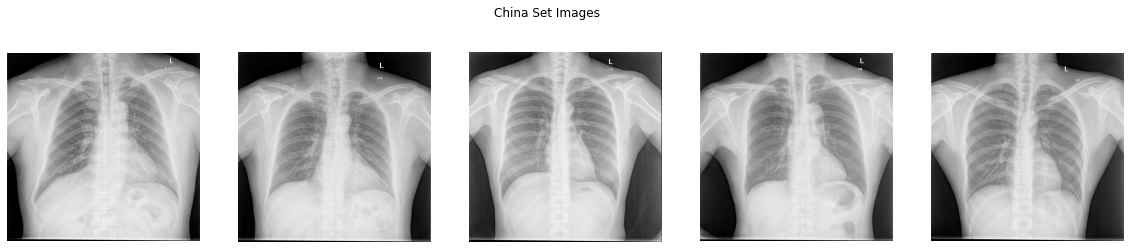

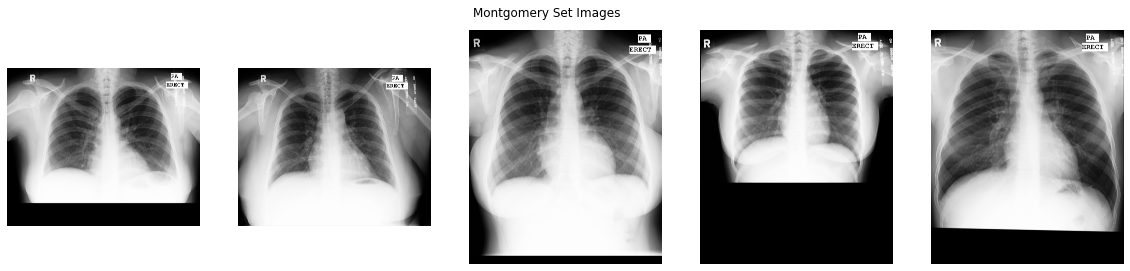

In [122]:
showImagesHorizontally(5,china_set_image_directory, 'China Set Images')
showImagesHorizontally(5,montgomery_set_image_directory, 'Montgomery Set Images')

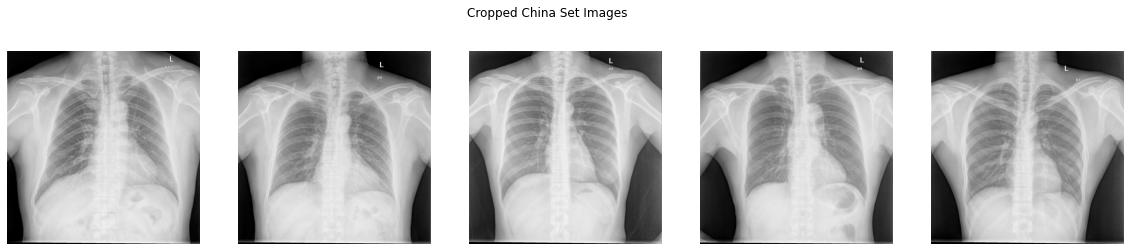

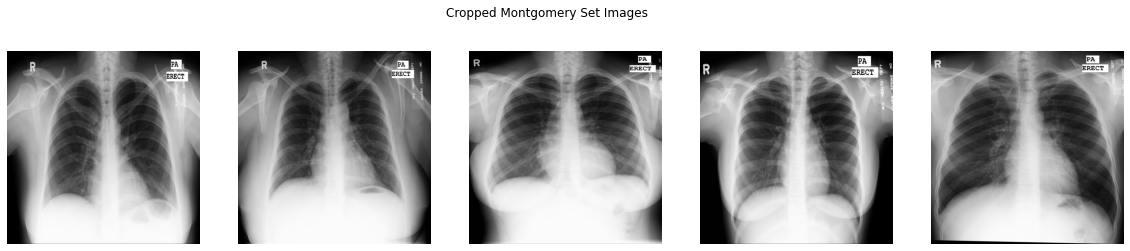

In [123]:
showImagesHorizontally(5, china_set_test_directory, 'Cropped China Set Images')
showImagesHorizontally(5, montgomery_set_test_directory, 'Cropped Montgomery Set Images')

In [14]:
image_stats = get_reference_image_statistics(china_set_test_directory)

In [245]:
!rm -r china_tiff/
!rm -r montgomery_tiff/

!mkdir china_tiff
!mkdir montgomery_tiff

In [292]:
china_tiff_directory = 'china_tiff/'
montgomery_tiff_directory = 'montgomery_tiff/'

z_score_normalization(china_set_test_directory, china_tiff_directory, image_stats,True)
z_score_normalization(montgomery_set_test_directory, montgomery_tiff_directory, image_stats,True)

['CHNCXR_0001_0.png', 'CHNCXR_0002_0.png', 'CHNCXR_0003_0.png', 'CHNCXR_0004_0.png', 'CHNCXR_0005_0.png', 'CHNCXR_0006_0.png', 'CHNCXR_0007_0.png', 'CHNCXR_0008_0.png', 'CHNCXR_0009_0.png', 'CHNCXR_0010_0.png', 'CHNCXR_0011_0.png', 'CHNCXR_0012_0.png', 'CHNCXR_0013_0.png', 'CHNCXR_0014_0.png', 'CHNCXR_0015_0.png', 'CHNCXR_0016_0.png', 'CHNCXR_0017_0.png', 'CHNCXR_0018_0.png', 'CHNCXR_0019_0.png', 'CHNCXR_0020_0.png', 'CHNCXR_0021_0.png', 'CHNCXR_0022_0.png', 'CHNCXR_0023_0.png', 'CHNCXR_0024_0.png', 'CHNCXR_0025_0.png', 'CHNCXR_0026_0.png', 'CHNCXR_0027_0.png', 'CHNCXR_0028_0.png', 'CHNCXR_0029_0.png', 'CHNCXR_0030_0.png', 'CHNCXR_0031_0.png', 'CHNCXR_0032_0.png', 'CHNCXR_0033_0.png', 'CHNCXR_0034_0.png', 'CHNCXR_0035_0.png', 'CHNCXR_0036_0.png', 'CHNCXR_0037_0.png', 'CHNCXR_0038_0.png', 'CHNCXR_0039_0.png', 'CHNCXR_0040_0.png', 'CHNCXR_0041_0.png', 'CHNCXR_0042_0.png', 'CHNCXR_0043_0.png', 'CHNCXR_0044_0.png', 'CHNCXR_0045_0.png', 'CHNCXR_0046_0.png', 'CHNCXR_0047_0.png', 'CHNCXR_0048

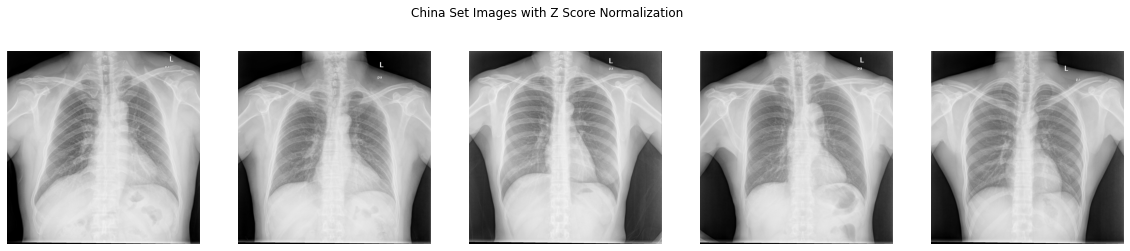

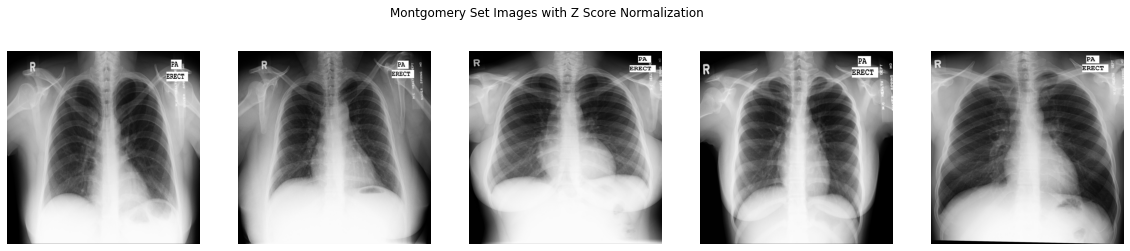

In [293]:
showImagesHorizontally(5, china_tiff_directory, 'China Set Images with Z Score Normalization')
showImagesHorizontally(5, montgomery_tiff_directory, 'Montgomery Set Images with Z Score Normalization')

1.0 0.0
(1500, 1500, 3)


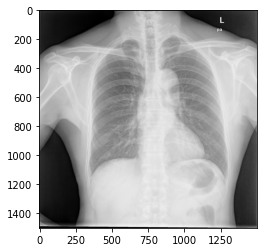

In [294]:
img = tiff.imread('china_tiff/image3.tiff') 

img = np.clip(img, 0, 1)

maxValue = np.amax(img)
minValue = np.amin(img)

print(maxValue,minValue)

print(img.shape)

figure()
imshow(img)

In [126]:
final_mse_values = mse_comparisons(china_set_test_directory, china_tiff_directory, True)
final_ssim_values = ssim_comparisons(china_set_test_directory, china_tiff_directory, True)
print(np.mean(final_mse_values), np.std(final_mse_values))
print(np.mean(final_ssim_values), np.std(final_ssim_values))

AttributeError: ignored

In [296]:
#average image generation

reference_path = montgomery_set_test_directory
reference_images = os.listdir(reference_path)

w,h = Image.open(reference_path + reference_images[0]).size
N = len(reference_images)

# Create a numpy array of floats to store the average (assume RGB images)
arr=np.zeros((h,w,3),np.float)

# Build up average pixel intensities, casting each image as an array of floats
for im in reference_images:
    imarr=np.array(Image.open(reference_path + im),dtype=np.float)
    arr=arr+imarr/N

# Round values in array and cast as 8-bit integer
arr=np.array(np.round(arr),dtype=np.uint8)

# Generate, save and preview final image
out=Image.fromarray(arr,mode="RGB")

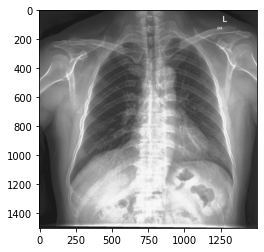

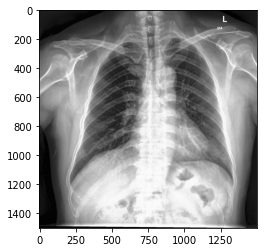

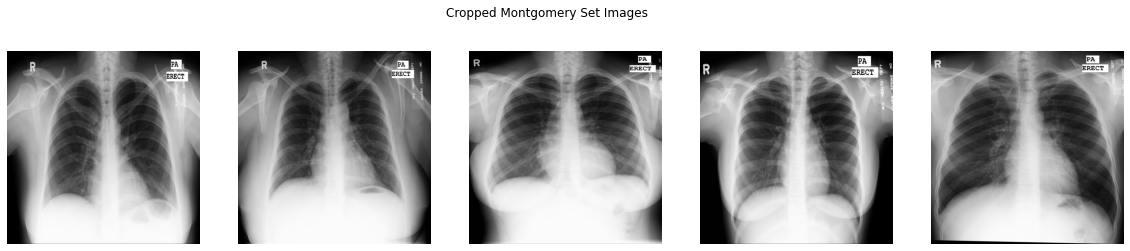

In [314]:
average_image = cv2.imread('Average.png')
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen_image = cv2.filter2D(average_image, -1, kernel)
test_image = cv2.imread('china_set_test/CHNCXR_0001_0.png')
#image_1

# figure()
# imshow(average_image)

# figure()
# imshow(sharpen_image)

matched = match_histograms(test_image, sharpen_image, multichannel=True)

figure()
imshow(matched)

clahe = cv2.createCLAHE(clipLimit = 0.5)
convert_matched = cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)
image_clahe = clahe.apply(convert_matched)

figure()
imshow(image_clahe,cmap='Greys_r')

showImagesHorizontally(5, montgomery_set_test_directory, 'Cropped Montgomery Set Images')